# FFI analysis for K2 C5, C16, C18 zero points

## Chapter 3: Results!

November 2019

We have results!

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = [10., 8.]

In [3]:
fns = {5:'FFI_C05_sep_Gaia.csv',16:'FFI_C16_sep_Gaia.csv',18:'FFI_C18_sep_Gaia.csv'}

In [4]:
df = pd.DataFrame()

In [5]:
for campaign, fn in fns.items():
    this_df = pd.read_csv('../data/K2/FFI_calibration/'+fn)
    this_df['campaign'] = campaign
    df = df.append(this_df, ignore_index=True)

In [6]:
df.campaign.value_counts()

5     2496
18    2451
16    1985
Name: campaign, dtype: int64

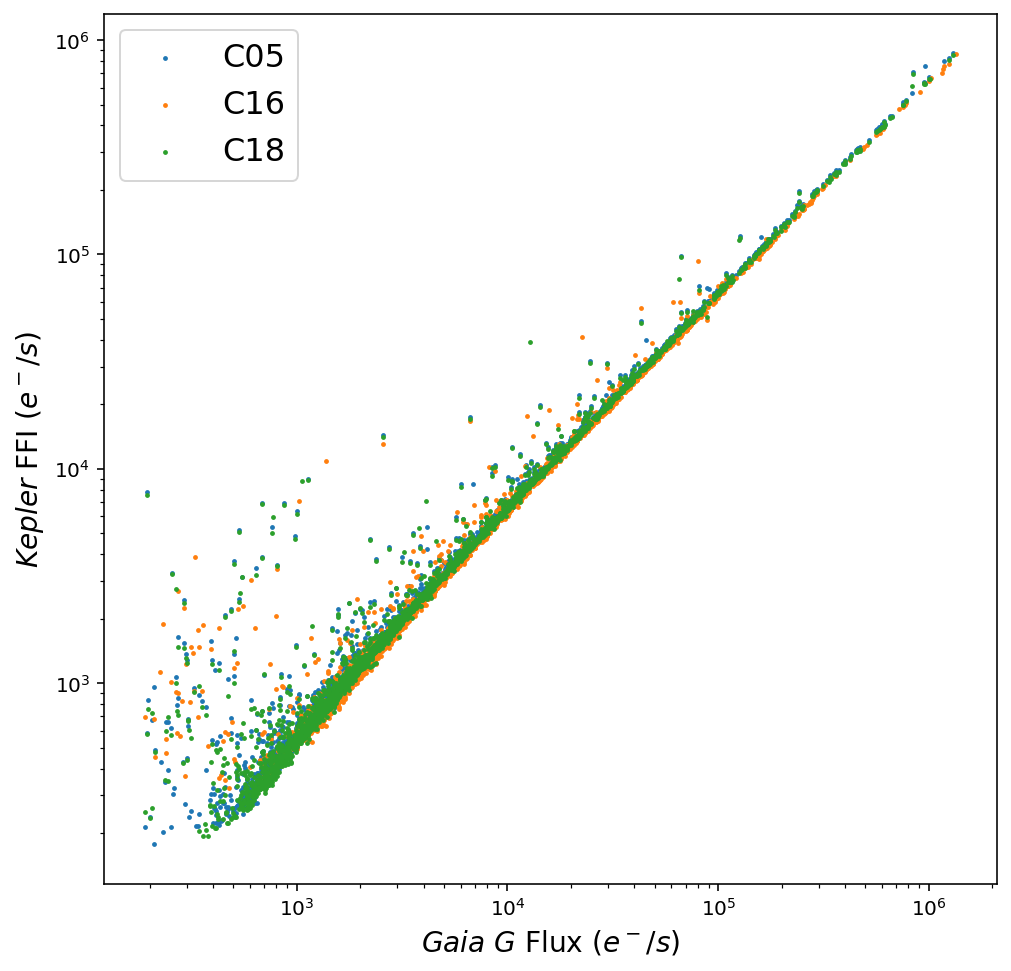

In [7]:
plt.figure(figsize=(8,8))

for campaign in (5,16,18):
    plt.scatter(df[df.campaign==campaign].FG, df[df.campaign==campaign].flux, 
                s=2, label='C{:02d}'.format(campaign))

plt.xlabel('$Gaia$ $G$ Flux ($e^-/s$)', fontsize=14)
plt.ylabel('$Kepler$ FFI ($e^-/s$)', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=16);

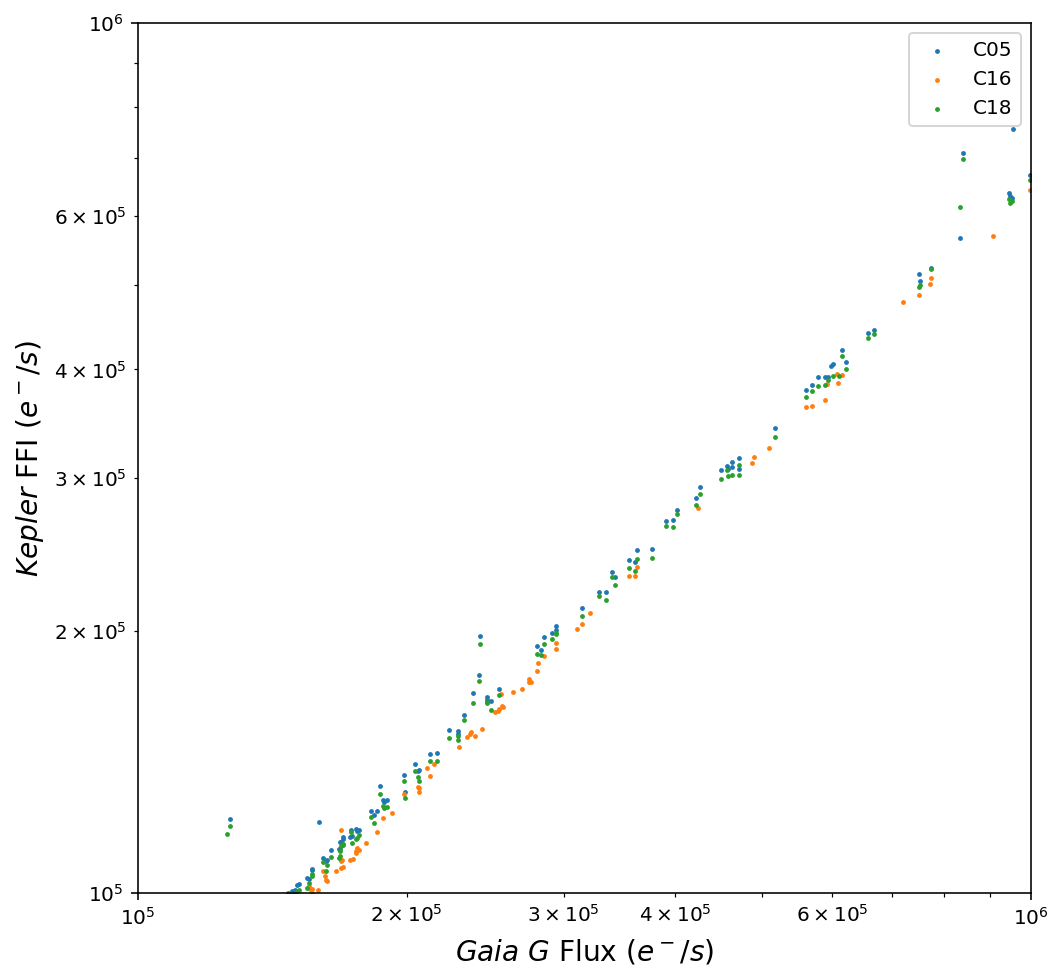

In [8]:
plt.figure(figsize=(8,8))

for campaign in (5,16,18):
    plt.scatter(df[df.campaign==campaign].FG, df[df.campaign==campaign].flux, 
                s=2, label='C{:02d}'.format(campaign))

plt.xlabel('$Gaia$ $G$ Flux ($e^-/s$)', fontsize=14)
plt.ylabel('$Kepler$ FFI ($e^-/s$)', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e5, 1e6)
plt.ylim(1e5, 1e6)
plt.legend();

Yeah, we definitely see some shift in zero points.

## Group by source

Will require some pandas-*fu*.

In [9]:
df.Source.value_counts().to_frame().Source.value_counts()

1    1900
2    1745
3     514
Name: Source, dtype: int64

Awesome!  514 sources were observed in all three campaigns!  Let's focus on these.

In [10]:
sources_with_3_campaigns = df.Source.value_counts().loc[lambda col: col == 3].index.values

In [11]:
df3 = df[df.Source.isin(sources_with_3_campaigns)]

We will *fix* one campaign as Ground truth, and get the relative zero-point shift to the others.

In [12]:
vec = df3.groupby(('Source')).flux.apply(lambda fluxes:fluxes/fluxes.iloc[0])

In [13]:
df3.loc[:,'normed_flux'] = vec.values

/Users/obsidian/anaconda3/envs/subsub/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/obsidian/anaconda3/envs/subsub/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
df3.groupby('campaign').normed_flux.describe()

,count,mean,std,min,25%,50%,75%,max
campaign,,,,,,,,
5,514.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
16,514.0,0.931341,0.042216,0.710061,0.919912,0.939261,0.950286,1.167500
18,514.0,0.980895,0.028686,0.735898,0.973349,0.982354,0.990643,1.200837


In [15]:
! ls ../results/

FFI_C5_16_18_calibration.png   subsub_PSD_celerite_model.png
FFI_C5_C18.png                 subsubb_PSD_celerite_model.png
figs


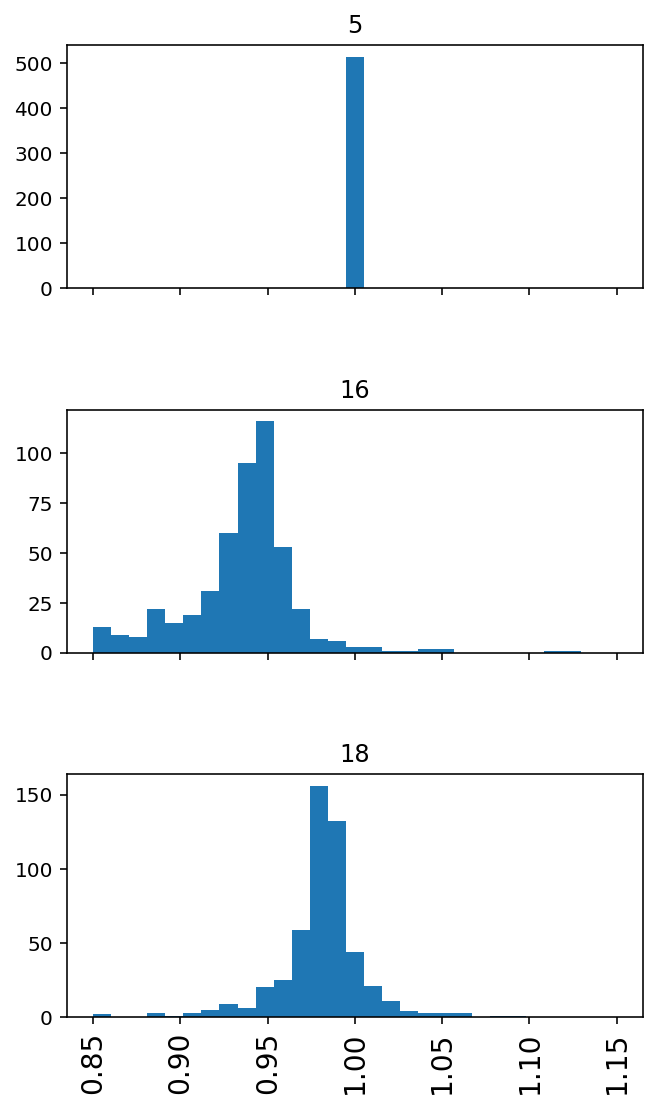

In [16]:
df3.hist(column='normed_flux', by='campaign', layout=(3,1), figsize=(5, 9), 
         sharex=True, bins=np.linspace(0.85, 1.15, 30), xlabelsize=14);
plt.savefig('../results/FFI_C5_16_18_calibration.png', dpi=300, bbox_inches='tight')

Woohoo! that's the answer!  We got an answer!

You can visualize it as a function of source flux.

In [17]:
df3 = df3.set_index('Source').sort_index()

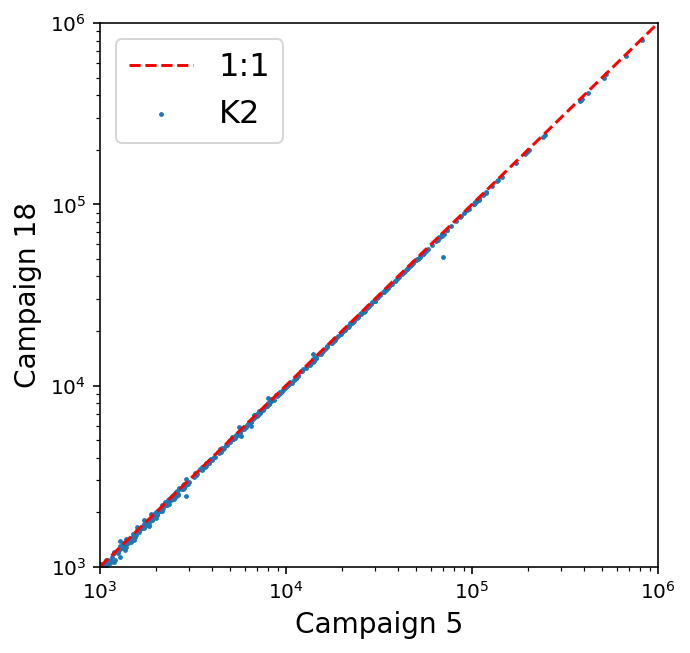

In [18]:
plt.figure(figsize=(5,5))


plt.scatter(df3[df3.campaign==5].flux, df3[df3.campaign==18].flux, 
                s=2, label="K2")

plt.plot([1e3, 1e6], [1e3, 1e6], 'r--', label='1:1')
plt.xlim(1e3, 1e6)
plt.ylim(1e3, 1e6)
plt.xlabel('Campaign 5', fontsize=14)
plt.ylabel('Campaign 18', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=16);
plt.savefig('../results/FFI_C5_C18.png', bbox_inches='tight', dpi=300)

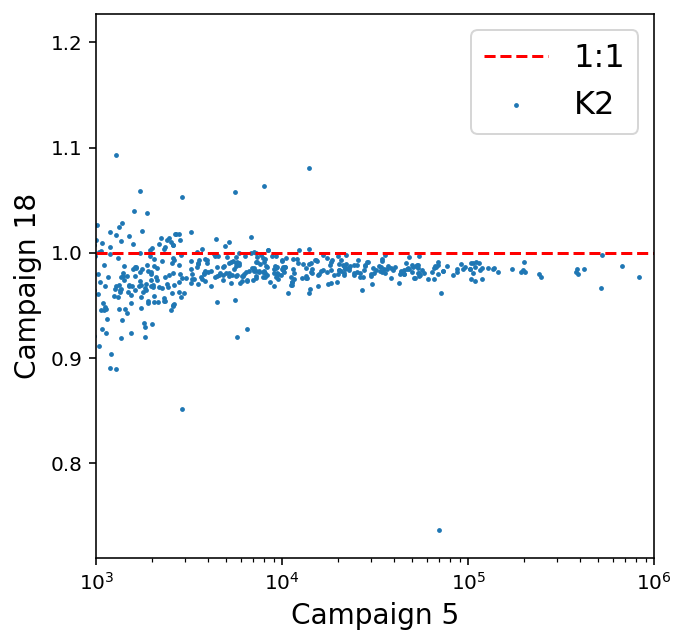

In [19]:
plt.figure(figsize=(5,5))


plt.scatter(df3[df3.campaign==5].flux, 
            df3[df3.campaign==18].flux/df3[df3.campaign==5].flux, 
                s=2, label="K2")

plt.plot([1e3, 1e6], [1,1], 'r--', label='1:1')
plt.xlim(1e3, 1e6)
#plt.ylim(1e3, 1e6)
plt.xlabel('Campaign 5', fontsize=14)
plt.ylabel('Campaign 18', fontsize=14)
plt.xscale('log')
plt.legend(fontsize=16);

Nice.  We could improve the estimate of the zero point through using the flux uncertainties, and taking a weighted average.